In [ ]:
import os
import math
import torch
import wandb
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchvision import transforms
import timm
from datetime import datetime

import matplotlib.pyplot as plt

from data.datamodule import Animal_DataModule
from data.datamodule import MultiClassImageDataModule

from models.model_facedetection import TransferLearningModuleMulticlass

f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Configuration

In the following steps, we will load the configuration settings using the `load_configuration` function. The configuration is stored in the `config` variable which will be used throughout the script.

In [2]:
from config.load_configuration import load_configuration
config = load_configuration()

PC Name: DESKTOP-MIKA
Loaded configuration from config/config_mika.yaml


### Setting Seeds for Reproducibility

To ensure comparable and reproducible results, we set the random seed using the `seed_everything` function from PyTorch Lightning. This helps in achieving consistent behavior across multiple runs of the notebook.

In [3]:
pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility

Seed set to 42


### Checking for GPU Devices

In this step, we check for the availability of GPU devices and print the device currently being used by PyTorch. This ensures that the computations are performed on the most efficient hardware available.

In [4]:
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Torch Version: ', torch.__version__)
print('Using device: ', device)
if device.type == 'cuda':
    print('Cuda Version: ', torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    torch.set_float32_matmul_precision('high')

Torch Version:  2.7.0+cu128
Using device:  cuda
Cuda Version:  12.8
NVIDIA GeForce GTX 1060 6GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Defining Transformations and Instantiating DataModule

In this step, we will define the necessary data transformations and initialize the `Animal_DataModule` with the provided configuration.

In [5]:
# TODO: Define transformations here

# Example for transformation
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to match EfficientNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])


dm = MultiClassImageDataModule(data_dir=config['path_to_split_aug_pics'], name_list=config['name_list'], transform=transform, batch_size=config['batch_size'], num_workers=2, persistent_workers=True)
dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

# Show a few images from the training set
from torchvision.utils import make_grid
def show_images(loader):
    images, labels = next(iter(loader))
    images = images[:16]  # Show only the first 16 images
    labels = labels[:16]
    grid = make_grid(images, nrow=4, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title('Sample Images')
    plt.axis('off')
    plt.show()
    print(labels[:16])  # Print corresponding labels
# show_images(train_loader)

print('Train dataset size:', len(dm.train_dataset))
print('Validation dataset size:', len(dm.val_dataset))
print('Test dataset size:', len(dm.test_dataset))
print('Example train data shape:', dm.train_dataset[0][0].shape)
print('Example train label:', dm.train_dataset[0][1])

Train dataset size: 13492
Validation dataset size: 2918
Test dataset size: 2908
Example train data shape: torch.Size([3, 300, 300])
Example train label: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [6]:
# Initialize the Wandb logger
wandb_config = {
    'project_name': config['wandb_project_name'],
    'experiment_name': config['wandb_experiment_name'],
    'batch_size': config['batch_size'],
    'max_epochs': config['max_epochs'],
    'learning_rate': config['learning_rate'],
}

wandb_logger = WandbLogger(
    project=config['wandb_project_name'],
    name=config['wandb_experiment_name'],
    config=config
    # save_dir=os.path.join(config['path_to_data'], 'logs')
)

# Initialize Trainer with wandb logger, using early stopping callback (https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)
trainer = Trainer(
    max_epochs=config['max_epochs'], 
    default_root_dir='model/checkpoint/', #data_directory, 
    accelerator="auto", 
    devices="auto", 
    strategy="auto",
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], 
    logger=wandb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Creating the Model

In this step, we will define the model architecture and print its summary using the `ModelSummary` utility from PyTorch Lightning. This provides an overview of the model's layers, parameters, and structure.

In [ ]:
def getEfficientNetB4_model(amount_of_trainable_linear_layers=1):
    """
    Function to get the EfficientNet B$ model with pretrained weights.
    Returns:
        model: A PyTorch model instance of EfficientNet B4.
    """
    # Load the EfficientNet B4 model with pretrained weights
    model = timm.create_model('efficientnet_b4', pretrained=True)
    
    # Modify the classifier for binary classification
    num_classes = len(config['name_list'])
    if amount_of_trainable_linear_layers == 1:
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    elif amount_of_trainable_linear_layers == 2:
        # If two linear layers are trainable, we add an intermediate layer
        model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),  # Add dropout for regularization
            torch.nn.Linear(model.classifier.in_features, 256),  # Intermediate layer
            torch.nn.ReLU(),  # Activation function
            torch.nn.Dropout(p=0.2),  # Another dropout layer
            torch.nn.Linear(256, num_classes)
        )
    
    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    return model, "TL_EfficientNetB4"

model, name = getEfficientNetB4_model(amount_of_trainable_linear_layers=config['trainable_linear_layers'])
model = TransferLearningModuleMulticlass(model, num_classes=len(config['name_list']))
print(ModelSummary(model, max_depth=-1))

## Train the model

In [ ]:
# Training of the model
trainer.fit(model=model, datamodule=dm)

# Finish wandb
wandb.finish()

# Save the trained model checkpoint
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = os.path.join(config['path_to_models'], f"{name}_model_{timestamp}.ckpt")
trainer.save_checkpoint(save_path)
print(f"Model saved to: {save_path}")
config['path_to_model'] = save_path

## Load pretrained model and perform evaluation

wandb: Currently logged in as: erzlektor (VDKI-Hasen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 91/91 [00:34<00:00,  2.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7682402729988098
        test_loss           0.16043710708618164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.16043710708618164, 'test_acc': 0.7682402729988098}]

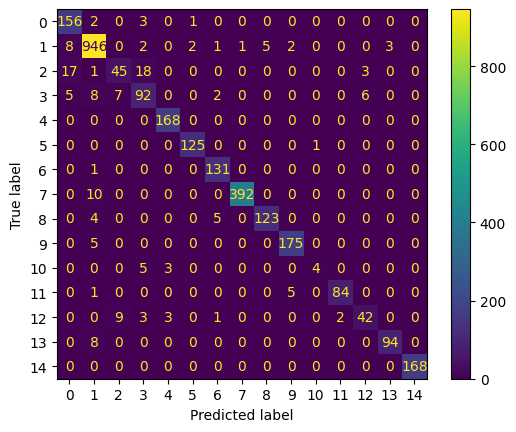

In [7]:
model = TransferLearningModuleMulticlass.load_from_checkpoint(
    config['path_to_model'],
    model=timm.create_model('efficientnet_b4', pretrained=False, num_classes=len(config['name_list'])),
    num_classes=len(config['name_list'])
)
# Put model in evaluation mode and move to correct device
model.eval()
trainer.test(model=model, dataloaders=test_loader)